Класс машины экстремального обучения

In [1]:
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
import numpy
import mnist
import numba as nb
from numba.experimental import jitclass
from numba import vectorize


@vectorize([nb.float64(nb.float64)])
def sigma_func(x):
    return 1 / (1 + numpy.exp(-x))


@jitclass([
    ('d', nb.int32),
    ('gamma', nb.float32),
    ('alpha', nb.float64[:, :]),
    ('b_vec', nb.float64[:]),
    ('beta', nb.float64[:, :]),
])
class ELM:

    def __init__(self, d=100, gamma=1e-6):
        self.d = d
        self.gamma = gamma

    def fit(self, x, y):
        n, m = x.shape
        # вычисление матрицы весов alpha
        self.alpha = numpy.random.uniform(-1, 1, (self.d, m))
        # вычисления вектора сдвигов b_vec и b
        self.b_vec = numpy.random.uniform(-1, 1, (self.d,))
        b = numpy.repeat(self.b_vec, n).reshape(-1, n).T
        # вычисление матрицы выходных весов beta
        h = numpy.dot(x, self.alpha.T)
        h = numpy.add(h, b)
        h = sigma_func(h)
        e = numpy.eye(self.d)
        hp = numpy.linalg.inv(numpy.dot(h.T, h) + self.gamma * e).dot(h.T)
        self.beta = numpy.dot(hp, y)
        pass

    def predict(self, x):
        n, m = x.shape
        # вычисление b
        b = numpy.repeat(self.b_vec, n).reshape(-1, n).T
        # вычисление h
        h = numpy.dot(x, self.alpha.T)
        h = numpy.add(h, b)
        h = sigma_func(h)
        return h.dot(self.beta)


Подготовка входных данных 

In [2]:
# загрузка изображений
train_data = mnist.train_images().reshape((60000, 784))
train_targets = mnist.train_labels()
test_data = mnist.test_images().reshape((10000, 784))
test_targets = mnist.test_labels()

# масштабирование изображений
scaled_data_train = MinMaxScaler().fit_transform(train_data)
scaled_data_test = MinMaxScaler().fit_transform(test_data)

# кодирование выходных меток класса
coded_train_targets = OneHotEncoder(sparse_output=False).fit_transform(train_targets.reshape(len(train_targets), 1))
coded_test_targets = OneHotEncoder(sparse_output=False).fit_transform(test_targets.reshape(len(test_targets), 1))

Обучение и предсказывание ELM(20 тестовых прогонов)

In [49]:
elm = ELM()

accuracy = numpy.empty((0))
learning_timings = numpy.empty((0))
predicting_timings = numpy.empty((0))

for i in range(20):
    # тренировка машины экстремального обучения
    ELM_start_learning = time.perf_counter()
    elm.fit(scaled_data_train, coded_train_targets)
    ELM_learning_time = time.perf_counter() - ELM_start_learning

    # предсказывание машиной экстремального обучения
    ELM_start_predicting = time.perf_counter()
    predicted_targets = elm.predict(scaled_data_train)
    ELM_predicting_time = time.perf_counter() - ELM_start_predicting

    uncoded_predicted_targets = numpy.argmax(predicted_targets, axis=1)
    uncoded_test_targets = numpy.argmax(coded_train_targets, axis=1)

    # вычисление accuracy для ELM
    true = 0
    false = 0
    for i in range(len(uncoded_predicted_targets)):
        if uncoded_predicted_targets[i] == uncoded_test_targets[i]:
            true += 1
        else:
            false += 1
            
    learning_timings = numpy.append(learning_timings, ELM_learning_time)
    predicting_timings = numpy.append(predicting_timings, ELM_predicting_time)
    accuracy = numpy.append(accuracy, true / (true + false) * 100)



Создание функции для отображения диаграмм

In [46]:
import matplotlib.pyplot as plt
import statistics


def display_diagram(x, y, title, ylim=None):
    fig, ax = plt.subplots()
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.grid(True)   # линии вспомогательной сетки
    ax.set_xlabel("test")
    ax.set_ylabel(title)
    text = 'dispersion: ' + str(statistics.variance(y))
    ax.text(0, 1.2, text,
        horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
    text = 'standard deviation: ' + str(numpy.std(y))
    ax.text(0, 1.15, text,
        horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
    text = 'average: ' + str(statistics.mean(y))
    ax.text(0, 1.1, text,
        horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)

Построение графиков точности и времени ELM для 20-ти тестовых прогонов(с указанием среднего значения, среднеквадратичного отклонения, дисперсии для каждой величины)

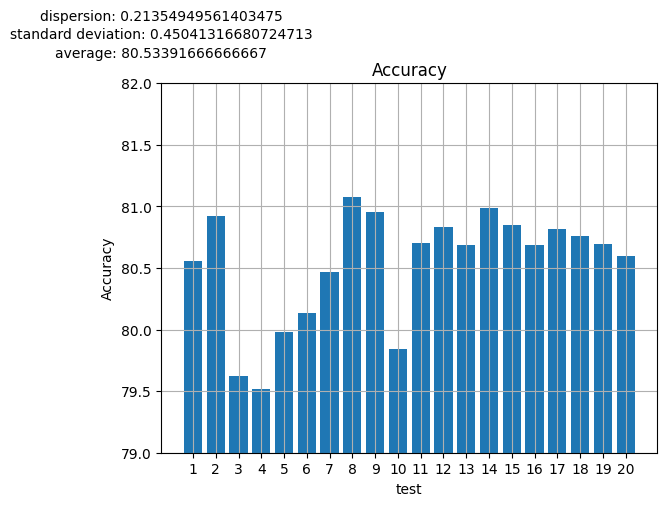

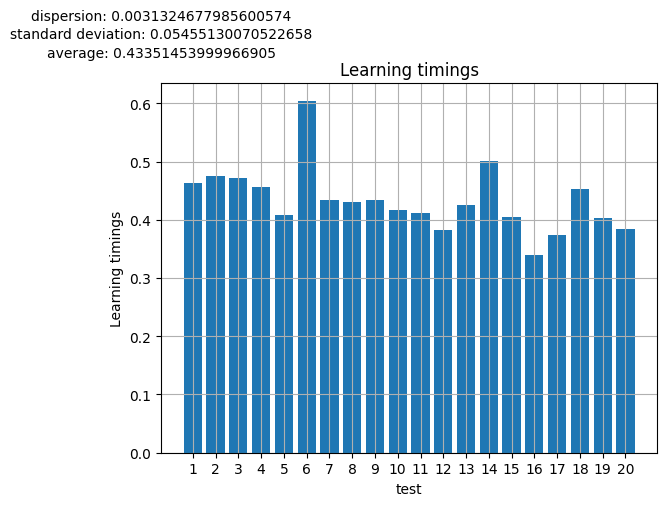

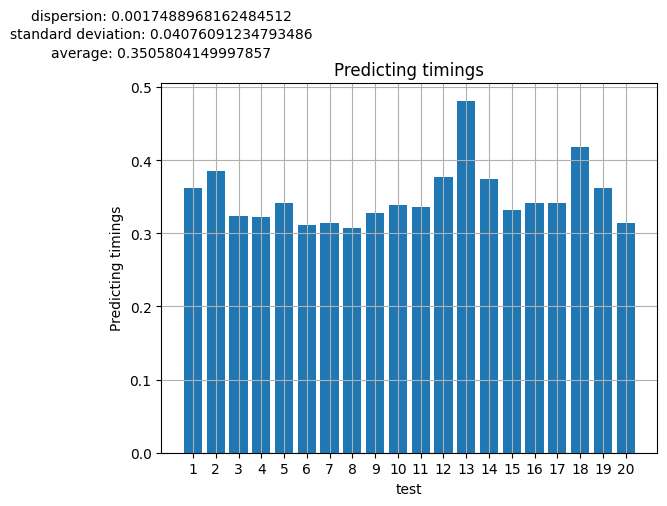

In [50]:
#график точности для ELM
display_diagram(numpy.arange(1, 21, 1), accuracy, "Accuracy", (79, 82))

#график времени обучения для ELM
display_diagram(numpy.arange(1, 21, 1), learning_timings, "Learning timings")

#график времени предсказания для ELM
display_diagram(numpy.arange(1, 21, 1), predicting_timings, "Predicting timings")

Обучение и предсказывание MLPClassifier(20 тестовых прогонов)

In [44]:
mlp_accuracy = numpy.empty((0))
mlp_learning_timings = numpy.empty((0))
mlp_predicting_timings = numpy.empty((0))

for i in range(20):
    MLP_start_learning = time.perf_counter()
    clf = MLPClassifier(random_state=1, max_iter=300, early_stopping=true).fit(scaled_data_train, train_targets)
    MLP_learning_time = time.perf_counter() - MLP_start_learning
    
    mlp_accuracy = numpy.append(mlp_accuracy, clf.score(scaled_data_test, test_targets))
    
    MLP_start_predicting = time.perf_counter()
    clf.predict(scaled_data_test)
    MLP_predicting_time = time.perf_counter() - MLP_start_predicting
    
    mlp_learning_timings = numpy.append(mlp_learning_timings, MLP_learning_time)
    mlp_predicting_timings = numpy.append(mlp_predicting_timings, MLP_predicting_time)

C:\Users\Alexandr\AppData\Local\pypoetry\Cache\virtualenvs\elm-mnist-utl0fQmw-py3.10\lib\site-packages\sklearn\utils\_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
C:\Users\Alexandr\AppData\Local\pypoetry\Cache\virtualenvs\elm-mnist-utl0fQmw-py3.10\lib\site-packages\sklearn\utils\_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
C:\Users\Alexandr\AppData\Local\pypoetry\Cache\virtualenvs\elm-mnist-utl0fQmw-py3.10\lib\site-packages\sklearn\utils\_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
C:\Users\Alexandr\AppData\Local\pypoetry\Cache\virtualenvs\elm-mnist-utl0fQmw-py3.10\lib\site-packages\sklearn\utils\_param_valida

Построение графиков точности и времени MLPClassifier для 20-ти тестовых прогонов(с указанием среднего значения, среднеквадратичного отклонения, дисперсии для каждой величины)

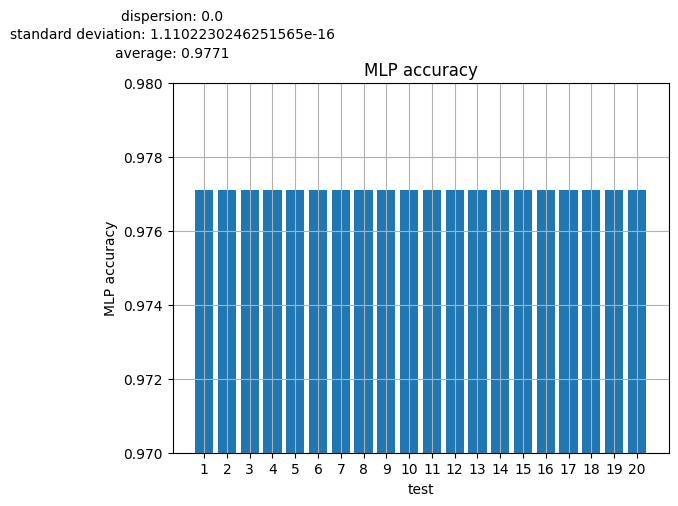

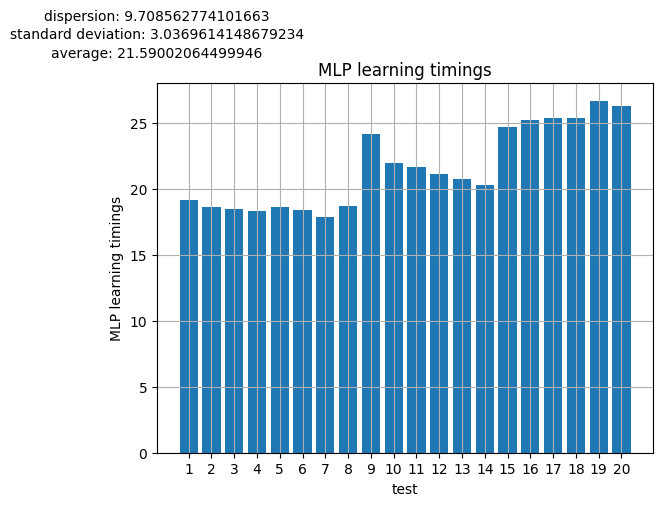

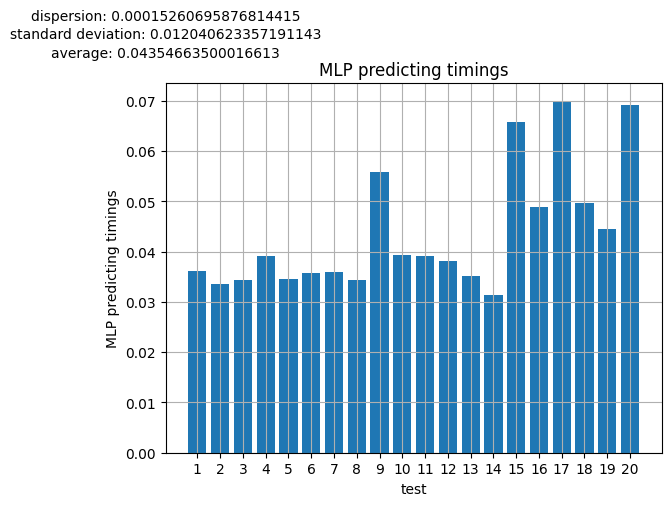

In [48]:
#график точности для MLP
display_diagram(numpy.arange(1, 21, 1), mlp_accuracy, 'MLP accuracy', (0.97, 0.98))

#график времени обучения для MLP
display_diagram(numpy.arange(1, 21, 1), mlp_learning_timings, 'MLP learning timings')

#график времени предсказания для MLP
display_diagram(numpy.arange(1, 21, 1), mlp_predicting_timings, 'MLP predicting timings')